## Bayesian errors-in-variables estimation of specific climate sensitivity (submitted)
#### D. Heslop, E. J. Rohling, G. L. Foster, and J. Yu

#### Notebook to demonstrate regression via maximum likelihood estimation (recreates Figure 2).

#### Import require libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

If you have TeX installed these commands will produce LaTeX-formatted plots. If you don't have TeX, then don't execute the commands.

In [2]:
# Enable LaTeX rendering in Matplotlib
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']

Define the functions to find the negative loglikelihood and perform the numerical integration

In [3]:
def negloglike(p, x_mus, x_sigmas, y_mus, y_sigmas, xlims):

    #INPUTS
    #p = array of polynomial coefficients
    #x_mus = array of data point x-values
    #x_sigmas = array of data point x-value uncertainty standard deviations
    #y_mus = array of data point y-values
    #y_sigmas = array of data point y-value uncertainty standard deviations
    #xlims = x limits for numerical integration 

    
    xts = np.linspace(xlims[0],xlims[-1],2000) #sequence of x-values between limits
    yts = np.polyval(p,xts) #corresponding y-values along polynomial
    t = np.sqrt((xts[:-1]-xts[1:])**2+(yts[:-1]-yts[1:])**2) #spacing between points along polynomial
    
    L = 0 #initial loglikelihood   
    for x_mu, x_sigma, y_mu, y_sigma in zip(x_mus,x_sigmas,y_mus,y_sigmas): #loop through all data points
        temp = norm.logpdf(xts,loc=x_mu,scale=x_sigma)+norm.logpdf(yts,loc=y_mu,scale=y_sigma) #find likelihood at each polynomial point
        Li = log_trapz(temp,t) #integrate the likelihoods
        L -= Li #combined into negative loglikelhood        
    
    return L

def log_trapz(y,dx):

    #intergrate using trapezoidal rule working in terms of logs
    #INPUTS
    #y = log of input array to integrate
    #dx = spacing between points
    
    n = len(y)
    a = np.max(y)
    ya = np.exp(y-a)    
    temp = (ya[:-1]+ya[1:])/2*dx
    
    return a + np.log(np.sum(temp)) 

Setup the example model and generate the data

In [4]:
#create "true" data
ptrue = np.array([3.0,0]) #line with gradient = 3 and intercept = 0
n, sigma_x, sigma_y = 50, 0.2, 0.1 # number of data points, x uncertainties and y uncertainties
xlims = np.array([-5,5]) #integration limits for likelihood estimation

np.random.seed(9999) #set for repeatability
fontsize = 14 #plot fontsize
order = 1 #use a straight-line model
x0 = np.random.rand(n) #collection of x points
y0 = np.polyval(ptrue,x0); #corresponding y-points
    
x_sigmas0 = np.ones(n)*sigma_x #x uncertainties
y_sigmas0 = np.ones(n)*sigma_y #y uncertainties
    
x_mus0 = x0 + np.random.randn(n)*x_sigmas0 #add x-errors to data
y_mus0 = y0 + np.random.randn(n)*y_sigmas0 #add y-errors to data

Fit the regression models

In [5]:
pOLS0 = np.polyfit(x_mus0,y_mus0,order) #OLS model
pNLL0 = minimize(negloglike, pOLS0, args=(x_mus0, x_sigmas0, y_mus0, y_sigmas0, xlims),method='SLSQP').x #MLE model

Plot the results

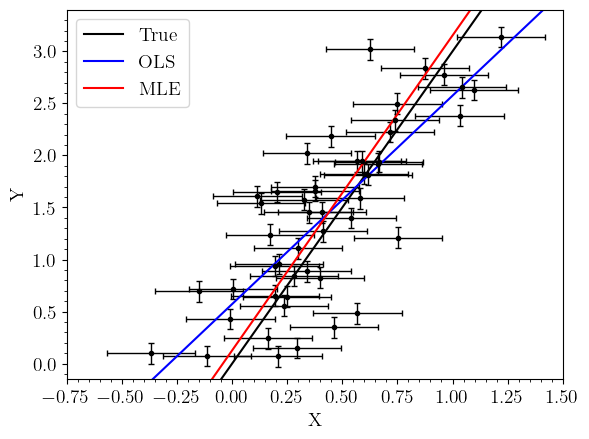

In [6]:
#plot the data
plt.errorbar(x_mus0, y_mus0, xerr=x_sigmas0, yerr=y_sigmas0, fmt='.', color = 'k', ecolor='k', capsize=2,elinewidth=1)
plt.minorticks_on()
plt.xlabel('X',fontsize=fontsize)
plt.ylabel('Y',fontsize=fontsize)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.plot(xlims,np.polyval(ptrue,xlims),'-k',label='True')

plt.plot(xlims,np.polyval(pOLS0,xlims),'-b',label='OLS')
plt.plot(xlims,np.polyval(pNLL0,xlims),'-r',label='MLE')

plt.xlim([-0.75,1.5])
plt.ylim([-0.15,3.4])

plt.legend(fontsize=fontsize)

Repeat fitting process demonstrated above 1000 times with different data sets

In [7]:
niter = 1000
pLSQ = []
pNLL = []
for i in range(niter):
    
    if np.mod(i,100) == 0:
        print(i)
    
    x0 = np.random.rand(n)
    y0 = np.polyval(ptrue,x0);
    
    x_sigmas = np.ones(n)*sigma_x
    y_sigmas = np.ones(n)*sigma_y
    
    x_mus = x0 + np.random.randn(n)*x_sigmas
    y_mus = y0 + np.random.randn(n)*y_sigmas

    ptemp = np.polyfit(x_mus,y_mus,order)
    soln = minimize(negloglike, ptemp, args=(x_mus, x_sigmas, y_mus, y_sigmas, xlims),method='SLSQP')
    if soln.success:
        pLSQ.append(ptemp)
        pNLL.append(soln.x)

pLSQ = np.asarray(pLSQ)
pNLL = np.asarray(pNLL)

0
100
200
300
400
500
600
700
800
900


Combine results into a single plot

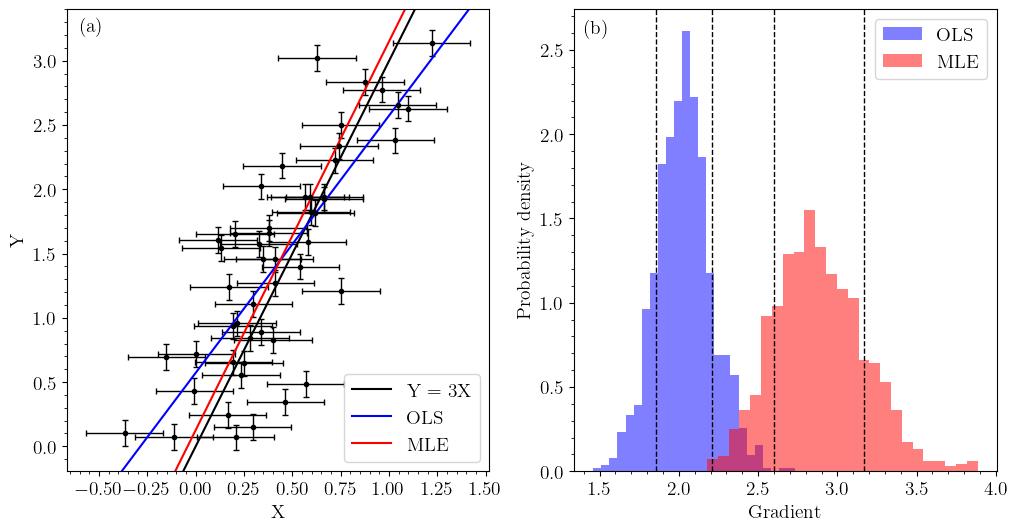

In [8]:
fig = plt.figure(figsize=(12,6))

###### Plot example regression (same as above)
plt.subplot(1,2,1)
plt.errorbar(x_mus0, y_mus0, xerr=x_sigmas0, yerr=y_sigmas0, fmt='.', color = 'k', ecolor='k', capsize=2,elinewidth=1)
plt.minorticks_on()
plt.xlabel('X',fontsize=fontsize)
plt.ylabel('Y',fontsize=fontsize)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

#add reference lines
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

plt.plot(xlim,np.polyval(ptrue,xlim),'-k',label='Y = 3X')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

xplot = np.linspace(xlim[0],xlim[1],101)
pOLS0 = np.polyfit(x_mus0,y_mus0,order)
plt.plot(xplot,np.polyval(pOLS0,xplot),'-b',label='OLS')

temp = minimize(negloglike, pOLS0, args=(x_mus0, x_sigmas0, y_mus0, y_sigmas0, xlims),method='SLSQP')
pNLL0 = temp.x
plt.plot(xplot,np.polyval(pNLL0,xplot),'-r',label='MLE')

plt.legend(fontsize=fontsize,loc='lower right')
plt.text(-0.6,3.225,'(a)',fontsize=fontsize)

###### plot Monte Carlo histograms
plt.subplot(1,2,2)
plt.hist(pLSQ[:,0],bins=25,density=True, alpha = 0.5,color='b', label = "OLS");
plt.hist(pNLL[:,0],bins=25,density=True, alpha = 0.5,color='r', label = "MLE");
plt.minorticks_on()
plt.xlabel('Gradient',fontsize=fontsize)
plt.ylabel('Probability density',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.gca().axvline(x=np.mean(pNLL[:,0])-np.std(pNLL[:,0]), color='k', linestyle='--', linewidth=1) #add 95% confidence interval
plt.gca().axvline(x=np.mean(pNLL[:,0])+np.std(pNLL[:,0]), color='k', linestyle='--', linewidth=1) #add 95% confidence interval

plt.gca().axvline(x=np.mean(pLSQ[:,0])-np.std(pLSQ[:,0]), color='k', linestyle='--', linewidth=1) #add 95% confidence interval
plt.gca().axvline(x=np.mean(pLSQ[:,0])+np.std(pLSQ[:,0]), color='k', linestyle='--', linewidth=1) #add 95% confidence interval

plt.legend(fontsize=fontsize)
plt.text(1.4,2.6,'(b)',fontsize=fontsize);